In [32]:
import subprocess
import geopandas as gdp
import pandas as pd
import fiona
import shapely
import contextily as cx
from contextily import Place
from osgeo import gdal

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pysal as ps
from libpysal.weights import Queen, Rook, KNN
from splot.esda import moran_scatterplot
import esda
import libpysal as lps
import os
import tempfile
import warnings

warnings.filterwarnings("ignore")

In [18]:
# configure data path
current_path = os.path.dirname(os.path.abspath("__file__"))
data_path = os.path.join(current_path, "..", "data")

data_path = os.path.normpath(data_path)

In [19]:
# virginia census track shapefiles

gdf = gdp.read_file(os.path.join(data_path, "tl_2020_51_tract.zip"))
gdf["GEOID"] = gdf["GEOID"].astype(int)

# load the broadband deployment data
df_broadband = pd.read_csv(os.path.join(data_path, "2021_processed", "VA_2021.csv"))
df_broadband["census_tract"] = df_broadband["BLKCODE2020"].apply(
    lambda code: (str(code).zfill(15))[:11]
)
bb_result = (
    df_broadband.groupby("census_tract")
    .agg(
        {
            "LTRatio2021": "mean",
            "MaxAdDown2021": "median",
            "MaxAdUp2021": "median",
        }
    )
    .reset_index()
)
bb_result["census_tract"] = bb_result["census_tract"].astype(int)


# load income df
df = pd.read_csv(os.path.join(data_path, "in_urb_ed_brb.csv"))
df_va = df[df.census_tract.astype(str).str.zfill(11).str.startswith("51")]
df_va.census_tract = df_va.census_tract.astype(int)

# groupby census_tract
income_result = (
    df_va.groupby("census_tract")
    .agg(
        {
            "median_income": "median",
            "with_degree": "mean",
            "urban_pop": "mean",
            "with_broadband": "mean",
        }
    )
    .reset_index()
)

# merge gdf with result df
merged_gdf = gdf.merge(bb_result, left_on="GEOID", right_on="census_tract").merge(
    income_result, on="census_tract"
)
merged_gdf.head(5)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,INTPTLON,geometry,census_tract,LTRatio2021,MaxAdDown2021,MaxAdUp2021,median_income,with_degree,urban_pop,with_broadband
0,51,085,320100,51085320100,3201,Census Tract 3201,G5020,S,328537534,2927606,...,-077.5726776,"POLYGON ((-77.74029 37.87408, -77.73998 37.874...",51085320100,0.000000,20.256,1.5,75619.000000,0.272481,0.000000,0.831198
1,51,085,321201,51085321201,3212.01,Census Tract 3212.01,G5020,S,11255521,16144,...,-077.3295398,"POLYGON ((-77.36115 37.60754, -77.36084 37.607...",51085321201,0.533898,987.000,35.0,73447.000000,0.172748,0.939611,0.807114
2,51,085,321202,51085321202,3212.02,Census Tract 3212.02,G5020,S,8887075,96758,...,-077.3462287,"POLYGON ((-77.38286 37.59526, -77.38280 37.595...",51085321202,0.524590,987.000,35.0,68167.000000,0.197946,0.998058,0.903470
3,51,085,320400,51085320400,3204,Census Tract 3204,G5020,S,58245255,348336,...,-077.5209363,"POLYGON ((-77.61233 37.75986, -77.61216 37.760...",51085320400,0.561290,987.000,35.0,74592.000000,0.293362,0.680431,0.877012
4,51,810,045000,51810045000,450,Census Tract 450,G5020,S,21420965,29350,...,-076.0308570,"POLYGON ((-76.06314 36.80147, -76.06114 36.802...",51810045000,0.883333,1000.000,35.0,77238.087623,0.436364,1.000000,0.774194


<Axes: xlabel='with_broadband', ylabel='Count'>

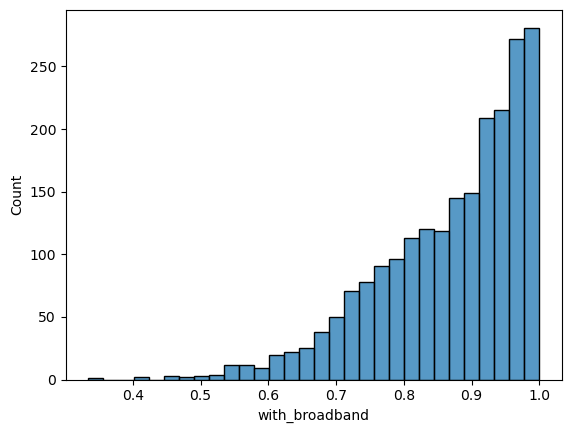

In [161]:
sns.histplot(merged_gdf["with_broadband"], bins=30)

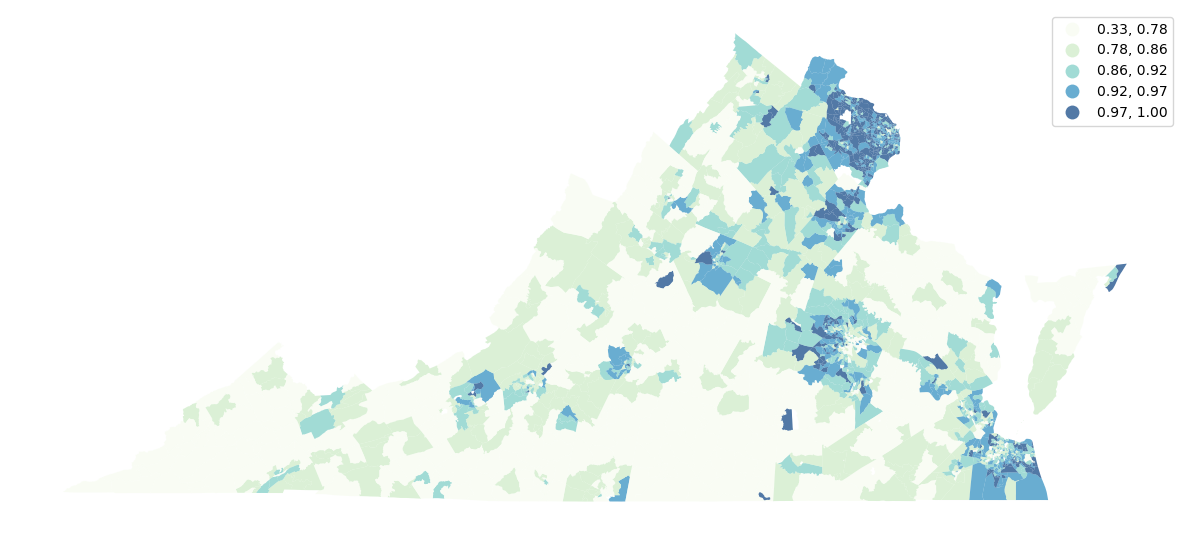

In [162]:
fig, ax = plt.subplots(figsize=(12, 12))

va = Place("Virginia")

merged_gdf.dropna(subset=["with_broadband"]).to_crs(epsg=4269).plot(
    "with_broadband",
    legend=True,
    scheme="quantiles",
    cmap="GnBu",
    k=5,
    ax=ax,
    alpha=0.7,
)

# cx.add_basemap(ax, crs=merged_gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
ax.axis("off")


plt.axis("off")
plt.tight_layout()

In [163]:
# define weights/queen in the virginia map
df = merged_gdf.dropna(subset=["with_broadband"])
wq = Queen.from_dataframe(df)
wq.transform = "r"

In [164]:
y = df["with_broadband"]
ylag = lps.weights.lag_spatial(wq, y)

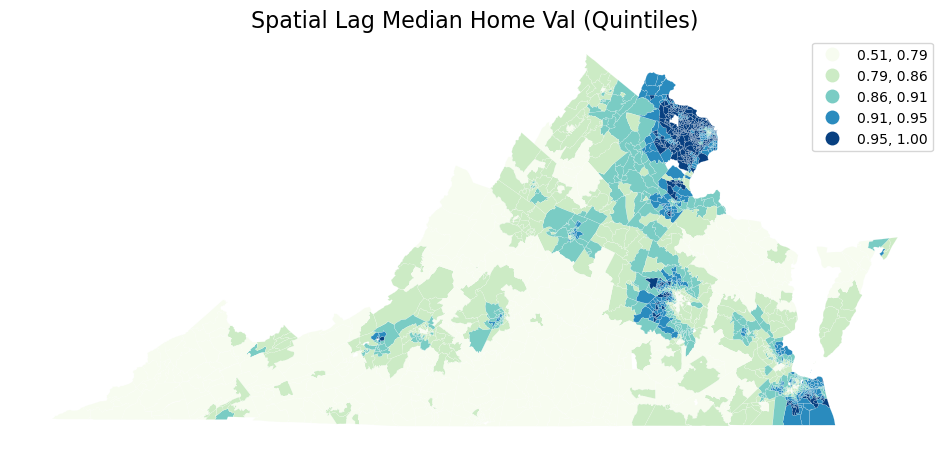

In [165]:
f, ax = plt.subplots(1, figsize=(12, 12))

df.assign(cl=ylag).plot(
    column="cl",
    scheme="quantiles",
    k=5,
    cmap="GnBu",
    linewidth=0.1,
    ax=ax,
    edgecolor="white",
    legend=True,
)

# cx.add_basemap(ax, crs=san_diego.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.axis("off")

plt.title("Spatial Lag Median Home Val (Quintiles)", fontsize=16)

plt.show()

In [166]:
# compute local moran

moran = esda.Moran_Local(y, wq)

In [169]:
moran.I

AttributeError: 'Moran_Local' object has no attribute 'I'

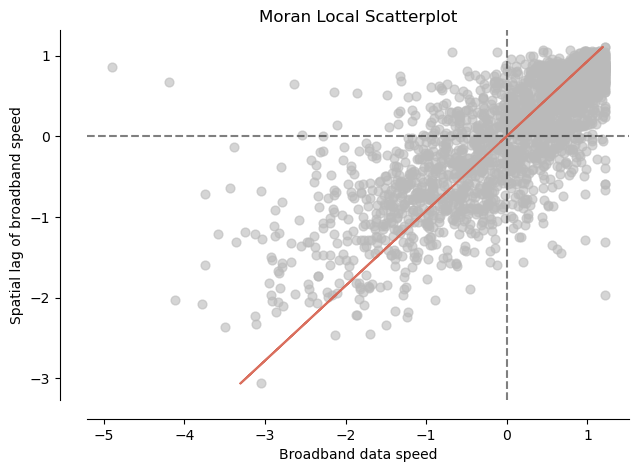

In [167]:
fig, ax = moran_scatterplot(moran)
ax.set_xlabel("Broadband data speed")
ax.set_ylabel("Spatial lag of broadband speed")
plt.show()

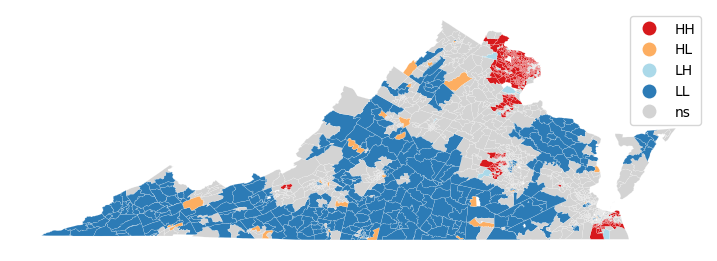

In [168]:
from splot.esda import lisa_cluster

lisa_cluster(moran, df, p=0.05, figsize=(9, 9))
plt.show()

## Load the Landsat data

In [3]:
lc_path = os.path.join(data_path, "landcover", "outOriginalReclassified.tiff")

landcover = gdal.Open(lc_path, gdal.GA_ReadOnly)

In [14]:
print("Metadata:")
metadata = landcover.GetMetadata()
for key, value in metadata.items():
    print(f"{key}: {value}")

Metadata:
AREA_OR_POINT: Area


In [23]:
print(landcover.GetProjection())

PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [24]:
albers_projection = """
    PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",
    SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],
    AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],
    PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],
    PARAMETER["false_easting",0],PARAMETER["false_northing",0],
    UNIT["metre",1,AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],AXIS["Northing",NORTH]]
"""

In [26]:
gdf_projected = gdf.to_crs(albers_projection)

<Axes: >

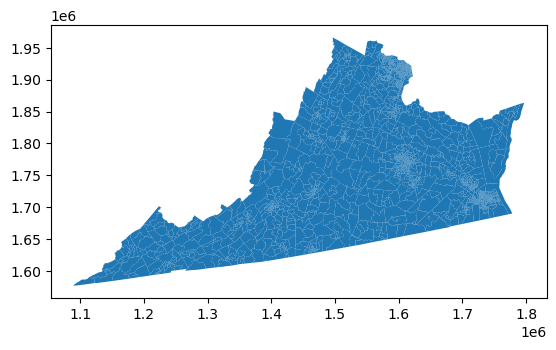

In [28]:
gdf_projected.plot()

In [29]:
# clipping virginia from the reclassified image

# boundary
virginia_boundary = gdf_projected.dissolve()

<Axes: >

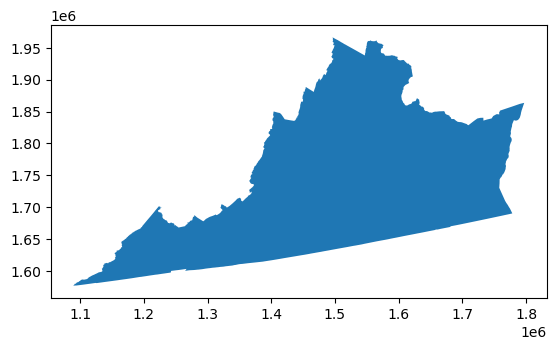

In [31]:
virginia_boundary.plot()

In [34]:
def clip_tiff_by_gdf(tiff_path, gdf, output_tiff_path):
    # Create a temp file
    with tempfile.TemporaryDirectory() as tmpdirname:
        temp_shapefile_path = os.path.join(tmpdirname, "temp_boundary.shp")
        gdf.to_file(temp_shapefile_path)

        # GDAL Warp command to clip the raster with the shapefile
        gdal.Warp(
            output_tiff_path,
            tiff_path,
            cutlineDSName=temp_shapefile_path,
            cropToCutline=True,
            dstNodata=-9999,
        )


# paths to your files
clipped_virginia_tiff_path = os.path.join(data_path, "landcover", "virginia_only.tif")

# clip the TIFF
clip_tiff_by_gdf(lc_path, virginia_boundary, clipped_virginia_tiff_path)

Warning 1: for band 1, destination nodata value has been clamped to -128, the original value being out of range.


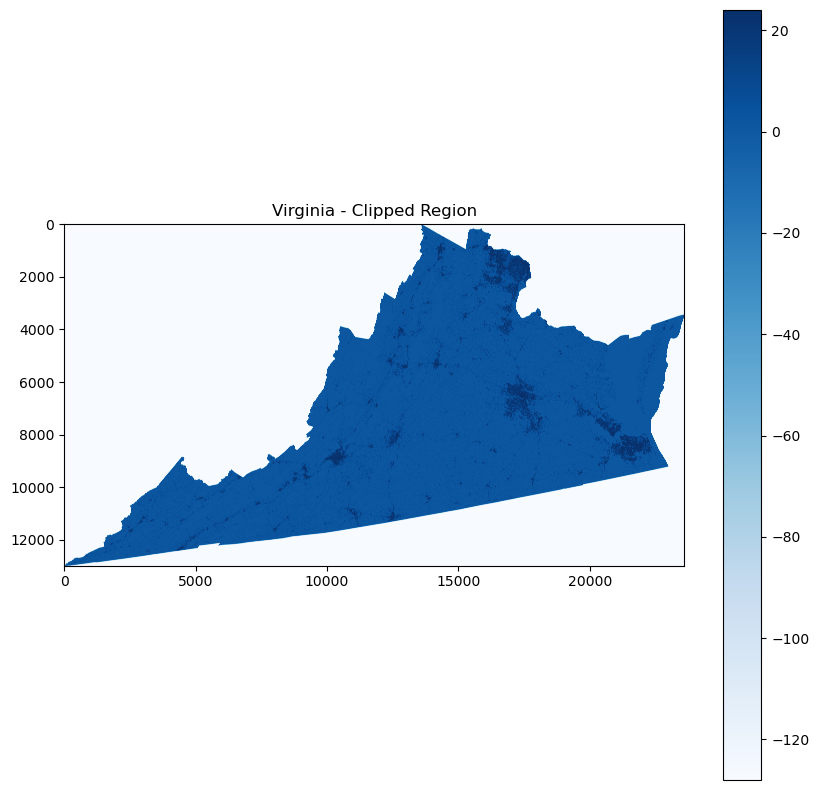

In [38]:
va_lc = gdal.Open(clipped_virginia_tiff_path, gdal.GA_ReadOnly)

if va_lc is None:
    print("File not opened.")

band = va_lc.GetRasterBand(1)
array = band.ReadAsArray()

va_lc = None

# Plotting
plt.figure(figsize=(10, 10))
plt.imshow(array, cmap="Blues")
plt.colorbar()
plt.title("Virginia - Clipped Region")
plt.show()